<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW4/CH_HW4_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=red> FBB:excellent work: technically flawless and more importantly thoughtful discussion of the results. well done!</font>

In [ ]:
!pip install wwo_hist

In [ ]:
#Import packages
import numpy as np
import pandas as pd
from datetime import timedelta as td
import pylab as plt
%pylab inline

from wwo_hist import retrieve_hist_data

import seaborn as sns

from fbprophet import Prophet, diagnostics
from fbprophet.plot import plot as fbplot

from google.colab import drive
drive.mount("/content/gdrive")

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/3.\ MSDS\ Courses/Machine \Learning \Time \Series

/content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series


# Data Acquisition
Data obtained is uber rides from April - September, 2014.

https://github.com/fivethirtyeight/uber-tlc-foil-response

In [ ]:
#Read in all csv files from folder
months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
df_list = []

for month in months:
  url = f'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-{month}14.csv'
  #uber = pd.concat([uber, pd.read_csv(url)], ignore_index=True)
  df_list.append(pd.read_csv(url))

uber = pd.concat(df_list, ignore_index=True)

In [ ]:
#Convert to datetime.
uber['Date/Time'] = pd.to_datetime(uber['Date/Time'])

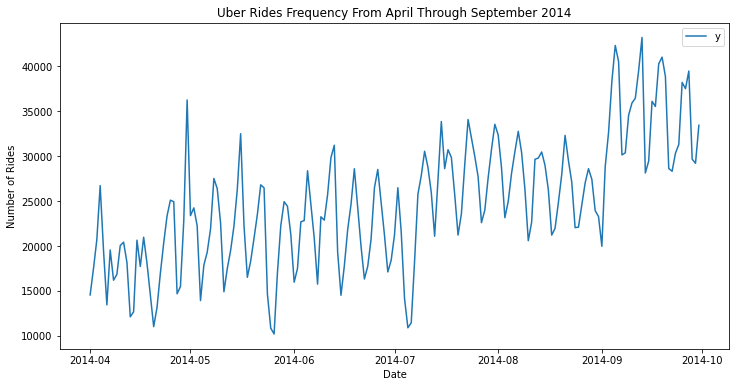

In [ ]:
#extract rides per day
ub_rides = uber[['Date/Time','Lat']].groupby(uber['Date/Time'].dt.date).count()
ub_rides.drop(columns='Date/Time', inplace=True)
ub_rides.reset_index(inplace=True)
ub_rides.columns = ['ds', 'y']

ub_rides.plot('ds', 'y', figsize=(12,6), xlabel='Date', 
              ylabel='Number of Rides', 
              title='Uber Rides Frequency From April Through September 2014');

Figure 1: Visualization of number of uber rides given per day througout April to September of 2014

<font color=red> FBB:what do you see? there are already obvious things you can comment on. there are obvious seasonalities, a general growing trend, some high and low points and a change of behavior in 9/14</font>

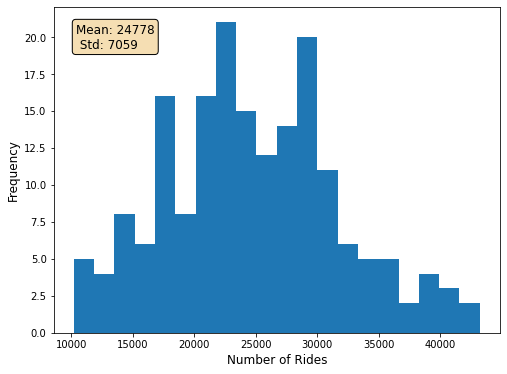

In [ ]:
#Plot distribution of Uber rides per day
mean = ub_rides.y.mean()
std = ub_rides.y.std()
txt = f'Mean: {round(mean)}\n Std: {round(std)}'

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(ub_rides['y'], bins=20)
ax.text(0.05, 0.95, txt, bbox={'boxstyle':'round', 'facecolor':'wheat'}, 
        verticalalignment='top', transform=ax.transAxes, fontsize=12)
ax.set_xlabel('Number of Rides', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

Figure 2: Distribution of Uber rides per day throughout April and September of 2014.

<font color=red> FBB: FBB:very nice!</font>

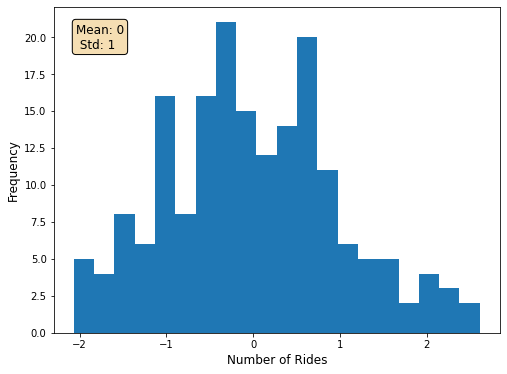

In [ ]:
#Standardize data and replot to confirm
ub_rides['y'] = (ub_rides['y'] - mean) / std

mean = ub_rides.y.mean()
std = ub_rides.y.std()
txt = f'Mean: {round(mean)}\n Std: {round(std)}'

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(ub_rides['y'], bins=20)
ax.text(0.05, 0.95, txt, bbox={'boxstyle':'round', 'facecolor':'wheat'}, 
        verticalalignment='top', transform=ax.transAxes, fontsize=12)
ax.set_xlabel('Number of Rides', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12);

<font color=red> FBB: FBB:great</font>

Figure 3: Standardized distribution of Uber rides per day (April-Sept, 2014)

#Model 1: Trends and Seasonality 

In [ ]:
#Fit Prophet to ub_rides and forecast 30 days into the future
simplem = Prophet().fit(ub_rides)

future = simplem.make_future_dataframe(periods=30)
forecast = simplem.predict(future)
forecast.iloc[-5:,:3]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower
208,2014-10-26,1.540104,0.019123
209,2014-10-27,1.553291,0.335508
210,2014-10-28,1.566478,0.838194
211,2014-10-29,1.579664,1.239458
212,2014-10-30,1.592851,1.536023


<Figure size 864x432 with 0 Axes>

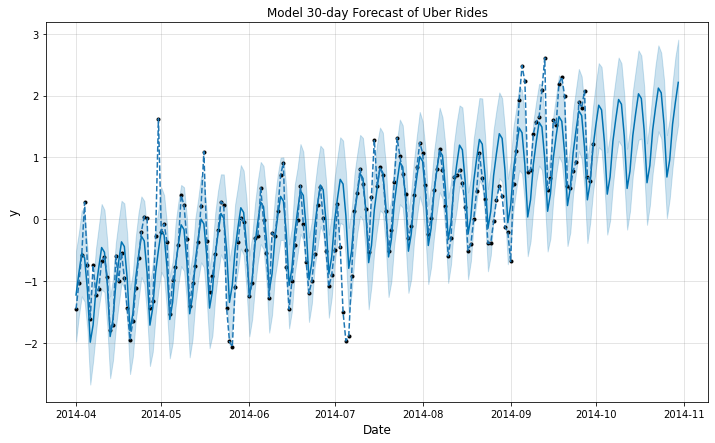

In [ ]:
#Plot model fit, forecast and uncertainty
plt.figure(figsize=(12,6))
fig = simplem.plot(forecast)
ax = fig.get_axes()[0]
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Model 30-day Forecast of Uber Rides')
plt.plot(ub_rides.ds, ub_rides.y, '--');

Figure 4: Prophet model fit to ub_rides data with 30-day forecast. The dark blue line indicates model predictions, the dashed blue line shows the standardized raw data, and the shaded region denotes model uncertainty.

<font color=red> FBB: FBB:good, but what do you see> are the predictions good? here is where you point out that several points (in correspondence to low and high values and of the change in september, are outside of the cofidence region. That justify creating more complex models</font>

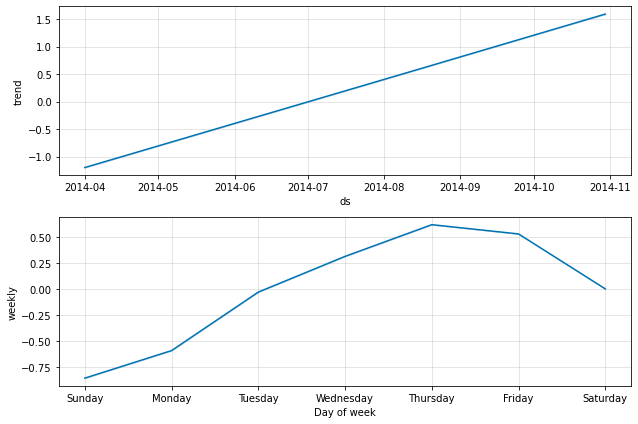

In [ ]:
#Plot individual components
fig = simplem.plot_components(forecast);

Figure 5: Decomposition of trend and weekly seasonality of ub_rides model fit and predictions.

<font color=red> FBB:again, describe what you see: there is a general growth trend and a weekly seasonality that peaks on thursday and is asymmetric</font>

In [ ]:
#Store crossvalidation data in dataframe
crv_df = diagnostics.cross_validation(simplem, '30 days')
crv_df.head(10)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-07-03,0.474445,-0.061372,0.964520,-0.450615,2014-07-02
1,2014-07-04,0.474838,-0.050482,0.991924,-1.505913,2014-07-02
2,2014-07-05,-0.263004,-0.766077,0.213263,-1.967473,2014-07-02
3,2014-07-06,-1.073989,-1.640369,-0.540102,-1.889129,2014-07-02
4,2014-07-07,-0.722523,-1.242921,-0.224553,-0.920533,2014-07-02
5,2014-07-08,-0.279925,-0.781345,0.232526,0.139581,2014-07-02
6,2014-07-09,0.199320,-0.303520,0.752596,0.430571,2014-07-02
7,2014-07-10,0.531239,-0.018294,1.087744,0.816479,2014-07-02
8,2014-07-11,0.531632,0.000878,1.019841,0.563032,2014-07-02
9,2014-07-12,-0.206210,-0.757045,0.320025,0.164090,2014-07-02


In [ ]:
def rchi(df):
  '''
  Calculate reduced r-chi (sigma=1) for cross-validated
  Prophet models
  '''
  return np.sum((df.y - df.yhat)**2) / (df.shape[0] - 1)

simplem_rchi = rchi(crv_df)
print(f'Reduced Chi-Squared for Model Cross Validation is {simplem_rchi}')

Reduced Chi-Squared for Model Cross Validation is 0.46482210972629


<font color=red> FBB:what does it mean? how does it compare to expectations?</font>

#Modeling Uber Rides with Additional Regressors from WWO Data

In [ ]:
#Read in data from WWO, merge to uber rides
wwo = pd.read_csv('WWO_data/New+york,ny.csv')[['date_time','tempC','precipMM']]
wwo['date_time'] = pd.to_datetime(wwo['date_time'])
wwo.rename(columns={'date_time':'ds'}, inplace=True)
wwo['ds'] = wwo['ds'].dt.date
ub_weather = ub_rides.merge(wwo, on='ds')

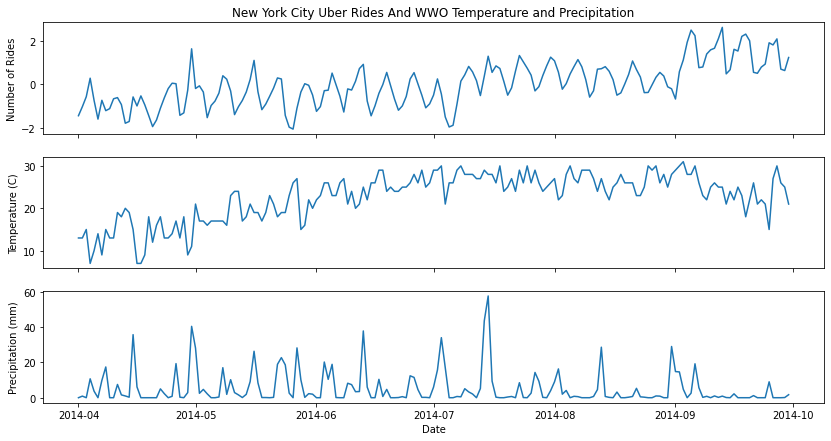

In [ ]:
#Plot Imported Data from WWO
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,7), sharex=True)

ax1.plot(ub_weather['ds'], ub_weather['y'])
ax1.set_ylabel('Number of Rides')
ax1.set_title('New York City Uber Rides And WWO Temperature and Precipitation')

ax2.plot(ub_weather['ds'], ub_weather['tempC'])
ax2.set_ylabel('Temperature (C)')

ax3.plot(ub_weather['ds'], ub_weather['precipMM'])
ax3.set_ylabel('Precipitation (mm)')
ax3.set_xlabel('Date');


Figure 6: Plot of target variable y (number of uber rides per day) as well as two additional regressors: the temperature in celcius and the precipitation in millimeters. Data for temperature and percipitation was taken from the World Weather Orginization.

<font color=red> FBB:very good</font>

In [ ]:
#Standardize tempC and precipMM
for col in ['tempC', 'precipMM']:
  ub_weather[col] = (ub_weather[col] - ub_weather[col].mean()) / ub_weather[col].std()
  print(f'{col} standardized mean: {ub_weather[col].mean()}')
  print(f'{col} standardized std: {ub_weather[col].std()}\n')


tempC standardized mean: 5.581449085547235e-17
tempC standardized std: 0.9999999999999996

precipMM standardized mean: -3.166865676799627e-16
precipMM standardized std: 1.0000000000000002



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


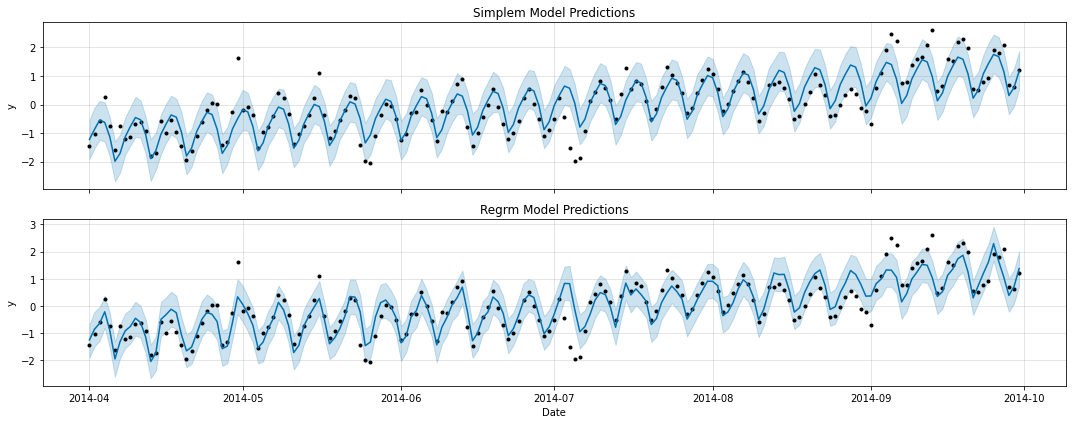

In [ ]:
#Define Model, add regressors, and fit to ubweather
regrm = Prophet()
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')
regrm.fit(ub_weather)

simplemcast = simplem.predict(ub_rides)
regrmcast = regrm.predict(ub_weather)

#Plot simplem and regrm predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,6), sharex=True)

simplem.plot(simplemcast, ax=ax1)
ax1.set_title('Simplem Model Predictions')
ax1.set_xlabel('')

regrm.plot(regrmcast, ax=ax2)
ax2.set_title('Regrm Model Predictions')
ax2.set_xlabel('Date');

fig.tight_layout()


Figure 7: Model predictions of Simplem and Regrm on in-sample data. Note that Simplem is trained only on the number of rides per day, whereas Regrm utilizes additional regressors in the form of data taken from WWO shown in Figure 6.

<font color=red> FBB:excellent, adn excellent for capturing the ambiguity in the instructions!</font>

In [ ]:
#Crossvalidate simplem and regrm
regrm_cv = diagnostics.cross_validation(regrm, '30 days')
regrm_rchi = rchi(regrm_cv)

print(f'Simplem Reduced Chi-Square: {simplem_rchi}')
print(f'Regrm Reduced Chi-Square: {regrm_rchi}')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

Simplem Reduced Chi-Square: 0.46482210972629
Regrm Reduced Chi-Square: 0.47710455504345534


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


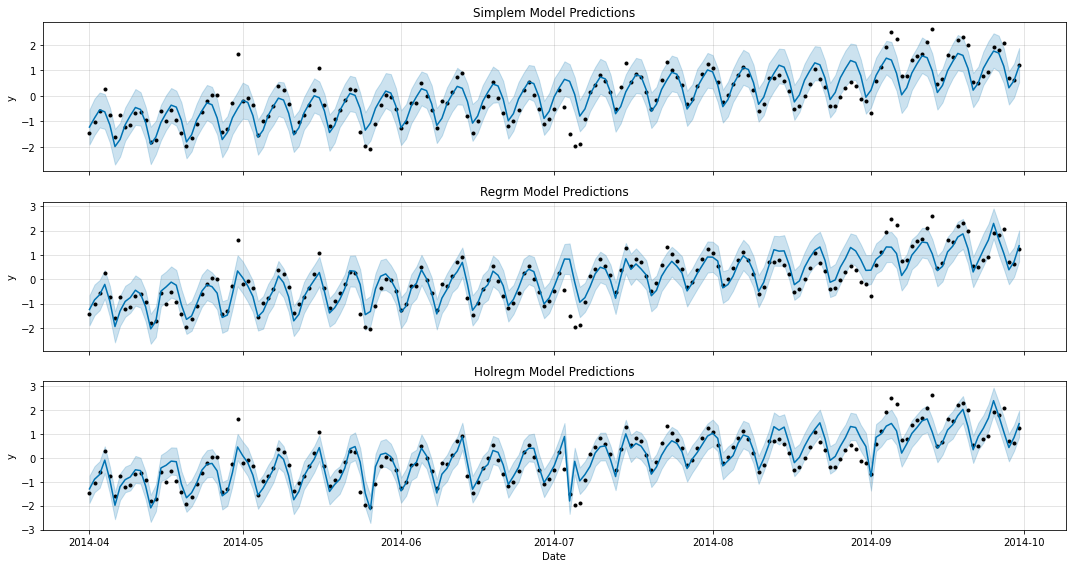

In [ ]:
#Add Holidays to Regrm Model
holregm = Prophet()
holregm.add_regressor('tempC')
holregm.add_regressor('precipMM')
holregm.add_country_holidays(country_name='US')
holregm.fit(ub_weather)

holregmcast = holregm.predict(ub_weather)

#Plot simplem and regrm predictions
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,8), sharex=True)

simplem.plot(simplemcast, ax=ax1)
ax1.set_title('Simplem Model Predictions')
ax1.set_xlabel('')

regrm.plot(regrmcast, ax=ax2)
ax2.set_title('Regrm Model Predictions')
ax2.set_xlabel('')

holregm.plot(holregmcast, ax=ax3)
ax3.set_title('Holregm Model Predictions')
ax3.set_xlabel('Date')

fig.tight_layout()


Figure 8: Model predictions of Simplem, Regrm, and Holregm on in-sample data. Simplem and Regrm are as previously described in Figure 7. Holregm is identical to Regrm with the exception that it utilizes US holidays as special 'events'.

<font color=red> FBB:good - but how does that improve the model? point out how points around 2014/07 and 2014/09 are now within the uncertainties</font>

In [ ]:
#Crossvalidate simplem, regrm, and holregrm
holregm_cv = diagnostics.cross_validation(holregm, '30 days')
holregm_rchi = rchi(holregm_cv)

print(f'Simplem Reduced Chi-Square: {simplem_rchi}')
print(f'Regrm Reduced Chi-Square: {regrm_rchi}')
print(f'Holregrm Reduced Chi-Square: {holregm_rchi}')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

Simplem Reduced Chi-Square: 0.46482210972629
Regrm Reduced Chi-Square: 0.47710455504345534
Holregrm Reduced Chi-Square: 0.39516846226090063


In [ ]:
#Prophet using Bayesian Framework MCMC=1000
regmc = Prophet(mcmc_samples=1000) #reducing samples to 1000 for efficiency
regmc.add_regressor('tempC')
regmc.add_regressor('precipMM')
regmc.add_country_holidays(country_name='US')
regmc.fit(ub_weather)

regmc_cast = regmc.predict(ub_weather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


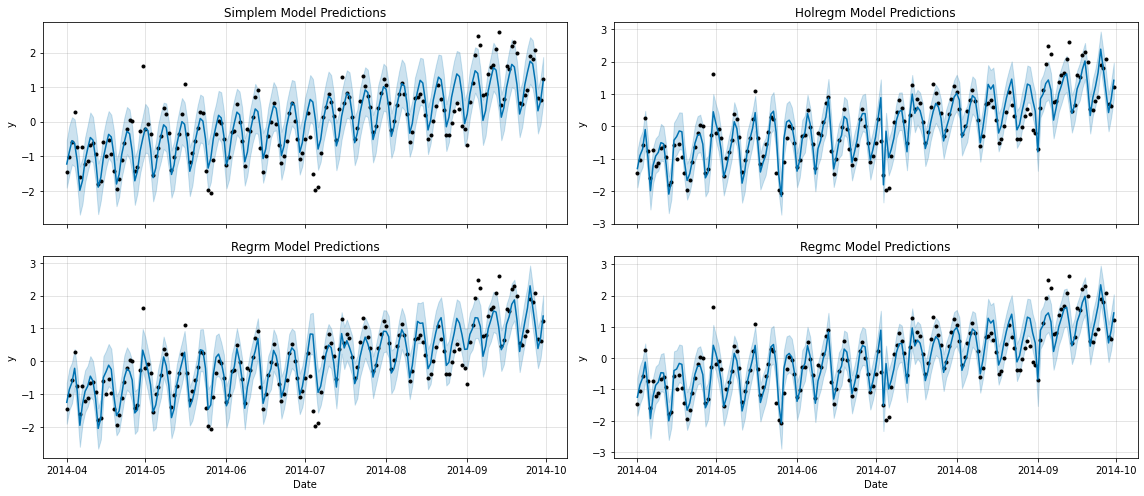

In [ ]:
#Plot simplem and regrm predictions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,7), sharex=True)

simplem.plot(simplemcast, ax=ax1)
ax1.set_title('Simplem Model Predictions')
ax1.set_xlabel('')

regrm.plot(regrmcast, ax=ax3)
ax3.set_title('Regrm Model Predictions')
ax3.set_xlabel('Date')

holregm.plot(holregmcast, ax=ax2)
ax2.set_title('Holregm Model Predictions')
ax2.set_xlabel('')

regmc.plot(regmc_cast, ax=ax4)
ax4.set_title('Regmc Model Predictions')
ax4.set_xlabel('Date')

fig.tight_layout()

Figure 9: Predictions of all time series models using Prophet on in-sample data. Simplem, Regrm, and Holregrm are as previously described. Regmc is identical to Holregrm except that it is trained by estimating the distribution of model parameters rather than by optimizing over an objective function.

<font color=red> FBB:excellent</font>

In [ ]:
#Crossvalidate simplem, regrm, holregm, and regmc
regmc_cv = diagnostics.cross_validation(regmc, '30 days')
regmc_rchi = rchi(regmc_cv)

print(f'Simplem Reduced Chi-Square: {simplem_rchi}')
print(f'Regrm Reduced Chi-Square: {regrm_rchi}')
print(f'Holregrm Reduced Chi-Square: {holregm_rchi}')
print(f'Regmc Reduced Chi-Square: {regmc_rchi}')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

Simplem Reduced Chi-Square: 0.46482210972629
Regrm Reduced Chi-Square: 0.47710455504345534
Holregrm Reduced Chi-Square: 0.39516846226090063
Regmc Reduced Chi-Square: 0.45725518979944435


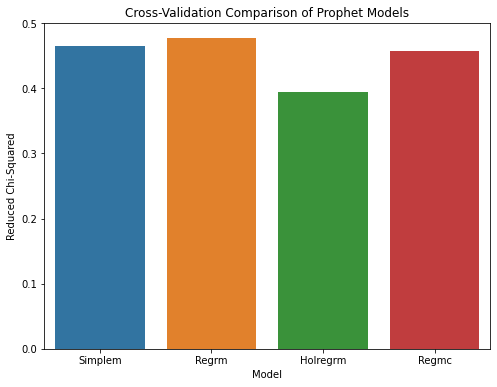

In [ ]:
cv_df = pd.DataFrame({'Model':['Simplem','Regrm','Holregrm','Regmc'],
                      'Rchi':[simplem_rchi, regrm_rchi, holregm_rchi,
                              regmc_rchi]})

plt.figure(figsize=(8,6))
sns.barplot(data=cv_df, x='Model', y='Rchi')
plt.ylabel('Reduced Chi-Squared')
plt.title('Cross-Validation Comparison of Prophet Models');

Figure 10: Comparison of Reduced Chi-Squared values for each Prophet model. The closer the Reduced Chi-Squared value is to 1, the better the model fit.

<font color=red> FBB:really good! I will talk about it in class. You _should_ expext rchi2 = 1 _if_ you had properly included your uncertainties. The fact that the models are below 1 mean that they are "too good to be true" because you underestimated the uncertainties. Some times this is used to evaluate our understanding of the uncertainties, and even inflate the uncertainties till the model is ~1. Of course that only work if you _expect_ to have a perfect model </font>

#Forecast 30-days into the Future using Regrm and Holregm

In [ ]:
#Import Data From September 30 to October 30
fw = pd.read_csv('WWO_data/FutureData/NY_forecast.csv')
fw['date_time'] = pd.to_datetime(fw['date_time']).dt.date
fw.rename(columns={'date_time':'ds'}, inplace=True)
fw.tail()

#standardize
fw.tempC = (fw.tempC - fw.tempC.mean()) / fw.tempC.std()
fw.precipMM = (fw.precipMM - fw.precipMM.mean()) / fw.precipMM.std()

#generate future df (same regardless of what model generates it)
future = regrm.make_future_dataframe(periods=30)
future.ds = future.ds.dt.date

In [ ]:
#Combine April-Sept weather data with October, merge to future
conc = pd.concat([ub_weather[['ds','tempC','precipMM']],fw], ignore_index=True)
conc.drop(183, axis='index') #because of how data imported from API row 183 is a duplicate

future = future.merge(conc, on='ds')
future.ds = future.ds.apply(pd.Timestamp) #ds must be timestamp for prophet

In [ ]:
#Predict on Regrm and Holregm models
regrm_oct = regrm.predict(future)
holregm_oct = holregm.predict(future)

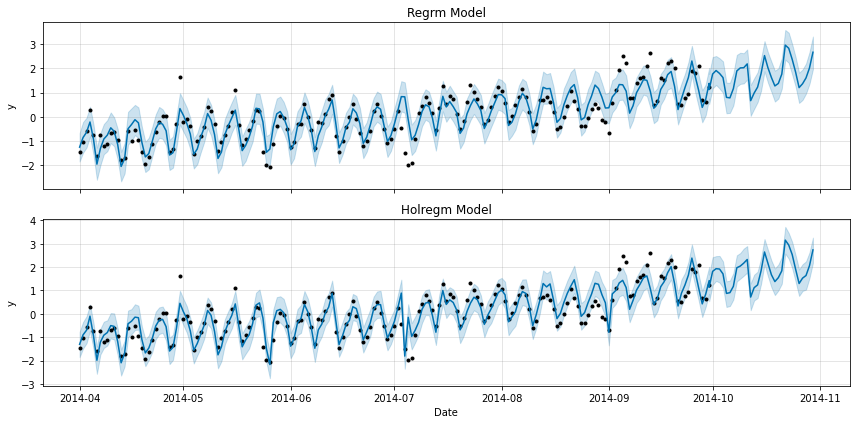

In [ ]:
#Plot Model predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True)

regrm.plot(regrm_oct, ax=ax1)
ax1.set_title('Regrm Model')
ax1.set_xlabel('')

holregm.plot(holregm_oct, ax=ax2)
ax2.set_title('Holregm Model')
ax2.set_xlabel('Date')

fig.tight_layout()

Figure 11: Forecast of number of Uber Rides by Regrm Model and Holregm Model throughout October 2014. Forecast of Regmc was not shown since with sufficiently many mcmc samples, there should be no difference between the parameters of Regmc and Holregm.